# Assignment A3  (PDS 2023/24): LLM Text Detection

Student: Rafail Mpalis

Registration Number: 1281/f3352308

## A. Data augmentation


First of all, in order to generate new essays/letter for the reason that we want a balanced dataset based on the the given dataset, we will calculate the essays/letters that was written by students and the essays/letter that was outputed by an LLM. 
We must mention that we are going to use GPT API with the model GPT 3.5 turbo-1106, which is the most cost effective and efficient for our task. 
For that purpose we built a new class with the name "PromptingGPT" in order to create as many instances as we desire for our different prompts. 
We must be able to create different instances for each augmentation for the reason that GPT model 3.5 turbo and most of these models give a limit to the tokens (16400 max tokens per window/input), thus we would not be able to generate as many essays as we want. This observation extracted after multiple tries with the API and multiple models such as text-davinci-003, 3.5-turbo instruct, 3.5-turbo-1106 etc. 

In [140]:
# Check the total number of essays/letter, total number of augmented by an LLM and total number written by students
train_data_df = pd.read_csv('data/train_essays.csv')
train_data_cols = train_data_df.columns.tolist()
sum_of_augmented = 0
for i in range(len(train_data_df)):
    if train_data_df.loc[i, train_data_cols[3]] == 1:
        sum_of_augmented += 1
print (f'The total number of essays/letter in the given dataset is: {len(train_data_df)}')
print (f'The total number of essays/letter that are generated by an LLM is: {sum_of_augmented}')
print (f'The total number of essays/letter that are written by a student is: {len(train_data_df) - sum_of_augmented}')

The total number of essays/letter in the given dataset is: 1378
The total number of essays/letter that are generated by an LLM is: 3
The total number of essays/letter that are written by a student is: 1375


### Results on the given dataset

As we can see from the above prints only 3 essays are generated by an LLM and the rest (1375) are written by a student. So, the given dataset is very inbalanced and we cannot proceed for the text classification. 
For that purpose we will use our class from GPT API in order to generate the same number of essays/letters as the number that was written by students. We used the two prompts that were given via the competition and we generated more in order to be able to generate new essays/letters from different prompts and achieve diversity into our data. 

Moreover, we built a new class with the name 'GenerateEssay' with the necessary functions in order to:
- a) Generate new unique id's for the new generated essays/letters.
- b) Create a new row with the proper data in order to be inserted to our combined dataframe.
- c) Create a mechanism that chooses randomly a prompt from the dataset of prompts. In the main fuction that generates the new texts we used this function in order to generate equally for both essays and letters.
- d)  The main function that generates new essays via GPT API. In this function we implemented library tqdm in order to check the remaining time. Furthermore, we re-calculated the necessary number of essays that we must generate in order to balance our data (we must generate 1372 essays/letters). For the reason that the competition mentioned that the extra information of source texts "may or may not have been provided as input to an LLM", we implemented in each iteration a random.choice of True or False so if it is True we will give in the LLM the extra info, however if it is False we will not give it. In each iteration we created a new instance of class "PromptingGPT" in order to avoid limit tokens and errors from openai. In each iteration we generate one essay and one letter based on the correct prompts. Finally, we observed that many times GPT was generating essays or letters that contain brackets in order the user to fill it [] (e.g. [Your Name]), thus we used regex in order to remove any of these from the generated text, for the reason that in the text classification process, the classifiers might achieve higher accuracy by catching these phrases (we expect that a student who uses a generated essay by an LLM, will definitely replace these).

Total cost for generation of 1372 new essays/letters (each 4K tokens) and its prompts (each prompt on average 1.1K tokens): 5.5 euros 

Total Time for the generation : 4h 56mins

In [98]:
import openai
import os
import re
from dotenv import load_dotenv

class PromptingGPT:

    # Load API key and organization from environment variables
    load_dotenv("secrets.env")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    openai.organization = os.getenv("OPENAI_ORGANIZATION")

    ClientOpenAi = openai.OpenAI(
            api_key= openai.api_key,
            organization= openai.organization
        )

    conversation_history = []
    def make_thread_prompt(self, prompt):
        """Combine previous messages with the current prompt and creating a thread
        with gpt-3.5-turbo-1106"""
        messages = [{'role': 'system', 'content': 'You are a helpful assistant.'}]
        for msg in self.conversation_history:
            messages.append({'role': 'user', 'content': msg})

        messages.append({'role': 'user', 'content': prompt})

        response = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=messages,
            max_tokens=4000,
        )

        # Extract and print the model's reply
        reply = response.choices[0].message.content
        print(reply)

        # Update conversation history
        self.conversation_history.append(prompt)
        self.conversation_history.append(reply)
        return reply

    def make_prompts_turbo(self, prompt):
        """
        Combine previous messages with the current prompt and creating a thread
        with gpt-3.5-turbo-1106
        """
        messages = [{'role': 'system', 'content': 'You are a helpful assistant.'}]

        messages.append({'role': 'user', 'content': prompt})

        response = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=messages,
            max_tokens=4000,
            temperature=0.9,
        )

        # Extract and print the model's reply
        reply = response.choices[0].message.content
        return reply

    def make_prompt_GPT_instruct(self, prompt):
        """Combine previous messages with the current prompt and creating a thread
        with gpt-3.5-instruct"""

        response = openai.completions.create(
            model="text-davinci-003",
            prompt=prompt,
            max_tokens=3950,
            temperature=0.7,  # 0 to 1 by  step of 0.1 O deterministic, 1 is very creative
        )

        # Extract and return the model's reply
        reply = response.choices[0].text
        return reply

In [2]:
import pandas as pd
import re
import uuid
import random
from GPT_Prompting import PromptingGPT
from tqdm import tqdm



class Generate_Essay:

    def generate_ids(self, train_data_df):
        """
        Creating unique id's for the new generated essays
        from the LLM. Use of library uuid
        :param: train_data_df: dataframe,
        :return: new_id: str (6 chars)
        """
        df_columns = train_data_df.columns.tolist()
        existing_ids = train_data_df[df_columns[0]].tolist()
        new_id = str(uuid.uuid4())[:6]
        while new_id in existing_ids:
            new_id = str(uuid.uuid4())[:6]

        return new_id

    def create_new_row(self, train_data_df, id, prompt_id, essay, generated=1):
        """
        Create a new row iot to insert it in the train data daraframe.
        :param train_data_df: dataframe,
        :param id: str,
        :param prompt_id: int,
        :param essay: str,
        :param generated: int,
        :return: dictionary
        """
        train_columns = train_data_df.columns.tolist()
        new_row_dict = {
            train_columns[0]: id,
            train_columns[1]: prompt_id,
            train_columns[2]: essay,
            train_columns[3]: generated,
        }

        return new_row_dict

    def choose_random_prompt(self, train_prompt_df, prompt_id):
        """
        Choose randomly one prompt from the many prompts that
        generated via the initial two prompts. Each initial prompt
        has the same number of generated in order the final number
        of generated essays to be balanced.
        :param train_prompt_df: dataframe
        :param prompt_id: int
        :return: string
        """
        prompt_cols = prompts_df.columns.tolist()
        selected_prompts = prompts_df[prompts_df[prompt_cols[0]] == prompt_id][prompt_cols[2]]
        random_prompt = selected_prompts.sample().iloc[0]

        return random_prompt

    def generate_essays(self, prompts_df, train_data_df):
        """
        Using the GPT API in order to generate new essays based on
        the prompts of file 'train_prompts.csv'. Will be generated the
        same number of essays as the number of student's essays in
        order to balance the train data.
        :param prompts_df: dataframe,
        :param train_data_df: dataframe,
        :return: dataframe
        """
        prompt_cols = prompts_df.columns.tolist()
        train_columns = train_data_df.columns.tolist()
        sum_of_augmented = 0
        for i in range(len(train_data_df)):
            if train_data_df.loc[i, train_columns[3]] == 1:
                sum_of_augmented += 1
        num_of_gen_essays = int((len(train_data_df) - sum_of_augmented)/2)
        with tqdm(total=num_of_gen_essays) as pbar:  # Check our time and iters remaining!
            for _ in range(num_of_gen_essays):
                # Create in each iter (inside loop) a new instance because GPT 3.5 has 16,385 limit tokens
                GPT_prompts = PromptingGPT()
                prompt1 = self.choose_random_prompt(train_data_df, 0)
                prompt2 = self.choose_random_prompt(train_data_df, 1)
                choice = random.choices([True, False])  # Give a choice to insert or not the source texts
                if choice:
                    prompt1 = prompt1 + ('\n') + prompts_df.loc[0, prompt_cols[3]]
                    prompt2 = prompt2 + ('\n') + prompts_df.loc[1, prompt_cols[3]]
                # Prompt No1 for prompt_id=0
                essay1 = GPT_prompts.make_prompts_turbo(prompt1)
                cleaned_essay1 = re.sub(r'\[.*?\]', '', essay1)
                new_id1 = self.generate_ids(train_data_df)
                new_row1 = self.create_new_row(train_data_df, id=new_id1, prompt_id=0, essay=cleaned_essay1)
                train_data_df = train_data_df._append(new_row1, ignore_index=True)
                # Prompt No2 for prompt_id=1
                essay2 = GPT_prompts.make_prompts_turbo(prompt2)
                cleaned_essay2 = re.sub(r'\[.*?\]', '', essay2)
                new_id2 = self.generate_ids(train_data_df)
                new_row2 = self.create_new_row(train_data_df, id=new_id2, prompt_id=1, essay=cleaned_essay2)
                train_data_df = train_data_df._append(new_row2, ignore_index=True)
                pbar.update(1)  # Update the progress bar

        return train_data_df


if __name__ == "__main__":

    # Create an instance of class Text_Classification
    gendata = Generate_Essay()

    # Read the .csv file of prompts iot take the prompts
    prompts_df = pd.read_csv('data/train_prompts.csv')
    prompt_cols = prompts_df.columns.tolist()
    # Read the .csv file of train data
    train_data_df = pd.read_csv('data/train_essays.csv')
    train_data_cols = train_data_df.columns.tolist()

    # Creation of new essays based on augmentation of LLM
    complete_train_data_df = gendata.generate_essays(prompts_df, train_data_df)

    complete_train_data_df = complete_train_data_df.set_index(train_data_cols[0])
    # Save the complete training set of essays (students/LLM)
    complete_train_data_df.to_csv('data/all_train_essays.csv')
    complete_train_data_df.to_html('data/all_train_essays.html')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 687/687 [4:55:50<00:00, 25.84s/it]


## Exploratory of our Dataset

We will explore our data in order to find any patterns, difference in length of essays/letter, or different words between each class.
Firstly, we plot the length of characters for each class via a histplot.
Secondly, we create two bar plots to check the number of outliers and the median for each class
Finally we plot the most common words for each class (student/LLM). We do not include small words that are not important to the text and are used in every essay(linking words such as 'the', 'of' etc).

In order to create an efficient exploratory I took a lot of help by the code of a user in kaggle with the following link:
https://www.kaggle.com/code/finlay/llm-detect-0-to-1

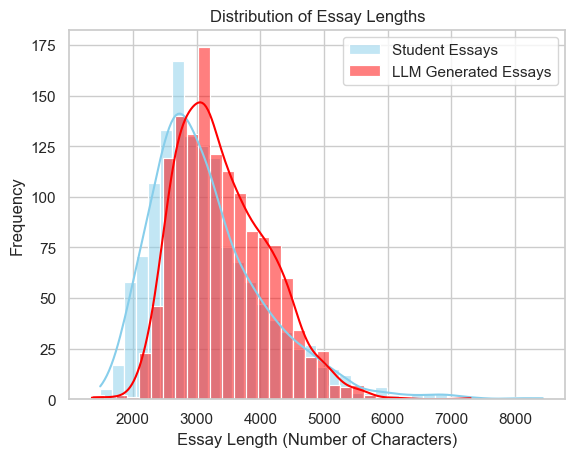

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

train_essays = pd.read_csv('data/all_train_essays.csv')

# Calculate the length of each essay and create a new column
train_essays['essay_length'] = train_essays['text'].apply(len)

# Distribution of essay lengths for student essays
sns.histplot(train_essays[train_essays['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# Distribution of essay lengths for LLM generated essays
sns.histplot(train_essays[train_essays['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Comments on the histplots

We can spot that the number of chars for each class is not very different, thus we expect the same size for each essay. The mean value for the student class is approximately 2800chars and the mean value for LLM class is 3300chars. So we will not train our model based on this result, in order to find patterns of length. 

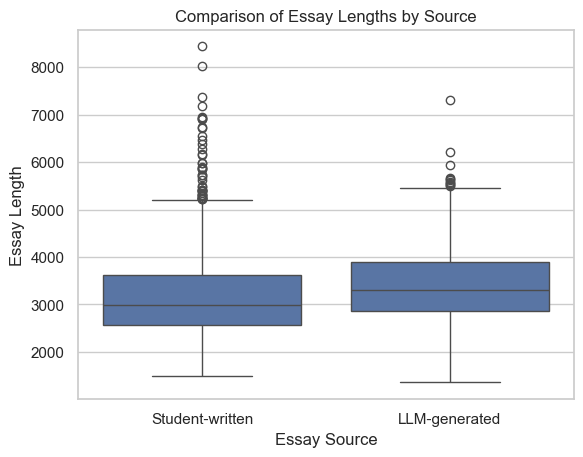

In [142]:
sns.boxplot(x='generated', y='essay_length', data=train_essays)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

### Comments on the barplots

We can spot that the essays that are written from students contain many outliers regarding the essay length. On the other hand LLM generated essays do not contain many outliers and are between 3000-4000 character. So, we expect that essays written by students may contain very large context.

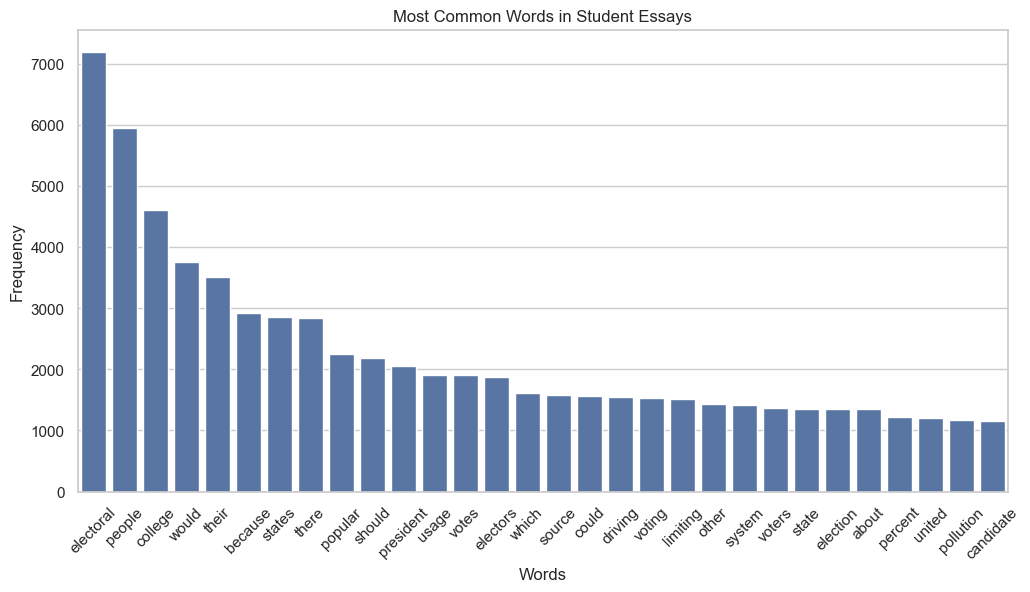

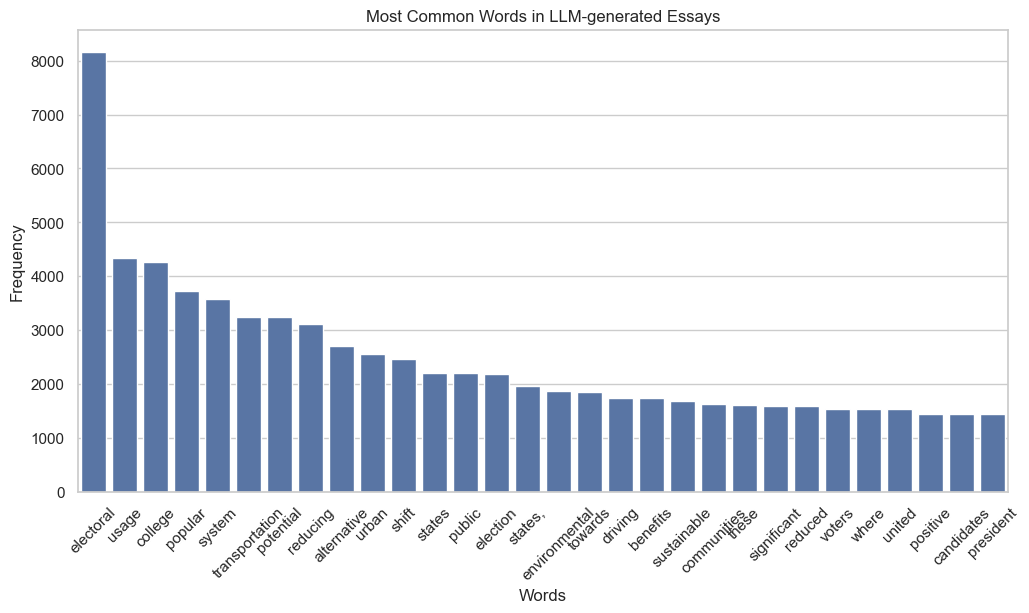

In [143]:
def most_common_words(text, num_words=30, title="Most Common Words"):
    """
     Plot the most common words for each class (student/LLM)
     Removing word with 1-4 chars in order to plot the most important
    :param text: string
    :param num_words: int
    :param title: string
    :return: barplot
    """  
    all_text = ' '.join(text).lower()
    words = all_text.split()
    word_freq = Counter(words)
    pattern = re.compile(r'\b\w{1,4}\b')  # Pattern in order to remove the small words (e.g. 'the')
    words_removed = []
    for key, value in word_freq.items():
        if re.match(pattern, key):
            words_removed.append(key)
    for word in words_removed:
        del word_freq[word]
    common_words = word_freq.most_common(num_words)

    # Plot the most common words
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

title_student = "Most Common Words in Student Essays"
most_common_words(train_essays[train_essays['generated'] == 0]['text'], title=title_student)
title_LLM = "Most Common Words in LLM-generated Essays"
most_common_words(train_essays[train_essays['generated'] == 1]['text'], title=title_LLM)

### Comments on most common words

We can spot that the essays that are written from students have some different most common words such as 'people'. In general we can spot that LLM generated essays contain more formal words (e.g. sustainable, potential). On the other hand student's written essays contain more common words such as 'limiting', 'voting', 'driving', so we expect a more simple approach from these essays. 

## Text Classification

We must mention that for each classifier we will submit a notebook in the competition from kaggle (LLM - Detect AI Generated Text), and we are going to choose our best classifier based on the accuracy that the competition ranked us. So, for each classifier we will submit a notebook for the competition and also a file called 'submission.csv' in order to be able to compete. Moreover, for each classifier we will print the necessary metrics (Accuracy, Precision, Recall, F1)in order to compare them and also the .csv named 'submission'.


### Simple Neural Network Classifier

For our first classifier we built a simple Neural Network with two layers. The first layer contains 32 neurons and the second which is the output, contain one neuron that gives us via the sigmoid function the probability for each essay/letter.
We used 10-fold cross validation for our training. We used 5 epochs, thus we made five (5) complete passes through the entire training dataset during the training phase.

As we can see from the results our metrics show that the classifier is very efficient. Moreover, the probabilities for the test set are actually much promising.

For this classifier the final score in the competition was 59.7%.

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense


train_essays_df = pd.read_csv('data/all_train_essays.csv')
essays_cols = train_essays_df.columns.tolist()

# Separate the essays and the labels
essays = train_essays_df[essays_cols[2]]
labels = train_essays_df[essays_cols[3]]

# Test essays from the given test set
test_essays_df = pd.read_csv('data/test_essays.csv')
test_essays = test_essays_df['text']

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(essays)
sequences = tokenizer.texts_to_sequences(essays)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)


# Define the neural network model
def create_model():
    model = Sequential()
    model.add(Embedding(max_words, 16, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(32, activation='relu'))  # Adding a new dense layer with 32 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model()
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_binary = np.round(y_pred)

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))

# Print the final metrics
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Tokenization for the given test set
tokenizer.fit_on_texts(test_essays)
sequences = tokenizer.texts_to_sequences(test_essays)
test_essays_X = pad_sequences(sequences, maxlen=max_len)

# Predict the probabilities for the given test set
predicted_test_set = model.predict(test_essays_X)
results_df = pd.DataFrame({'id':test_essays_df['id'], 'generated': predicted_test_set[:, 0]})
results_df = results_df.set_index('id')
print(results_df)

# Save the results to a CSV file
results_df.to_csv('data/submission_NN.csv')

9/9 [==============================] - 0s 2ms/step
Accuracy: 0.9985
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       137
           1       1.00      0.99      1.00       138

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

1/1 [==============================] - 0s 23ms/step
          generated
id                 
0000aaaa   0.712660
1111bbbb   0.712292
2222cccc   0.715106


### Support Vector Machines Classifier

For our second classifier we implemented a Support Vector Machines (SVM) classifier. The kernel of this classifier is linearly which means that is being applied to solve a linearly separable problem. We tried used the non-linearly separable classifier (kernel: 'rbf') and the results were very unefficient, so we kept the linear case.

As we can see from the results our metrics show that the classifier are very efficient. Moreover, the probability for the test set is the best we expected.

For this classifier the final score in the competition was 50% (expected low results due to linearity).

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

train_essays_df = pd.read_csv('data/all_train_essays.csv')
essays_cols = train_essays_df.columns.tolist()

# Separate the essays and the labels
essays = train_essays_df[essays_cols[2]]
labels = train_essays_df[essays_cols[3]]

# Test essays from the given test set
test_essays_df = pd.read_csv('data/test_essays.csv')
test_essays = test_essays_df['text']

# Convert essays to a bag-of-words representation
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 4))
X = vectorizer.fit_transform(essays)
y = np.array(labels)
test_essays_X = vectorizer.transform(test_essays)

# Define the SVM model
svm_model = SVC(kernel='linear', probability=True)

# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the SVM model
    svm_model.fit(X_train, y_train)

    # Predictions
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Print the final metrics
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Predict the probabilities for the given test set
predicted_test_set = svm_model.predict(test_essays_X)
results_df = pd.DataFrame({'id':test_essays_df['id'], 'generated': predicted_test_set})
results_df = results_df.set_index('id')
print(results_df)

# Save the results to a CSV file
results_df.to_csv('data/submission_SVM.csv')

Accuracy: 0.9989
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       138

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

          generated
id                 
0000aaaa          1
1111bbbb          1
2222cccc          1


### Deep Neural Network Classifier

For our third classifier we built a Deep Neural Network with five (5) layers. The first layer contains 16 neurons and is an 'Embedding' layer in order to transform each word (represented as an integer) into a dense vector of length 16.
The second and third layer contains 64 neurons each and they use the LSTM model (Long Short Memory Term) in order to capture dependencies and patterns over longer sequences.
The fourth layer contains 64 neuron and uses as activation function the ReLU.
The last layer contains 1 neuron that gives us via the sigmoid function the probability for each essay/letter.
We used 10-fold cross validation for our training. We used 5 epochs, thus we made five (5) complete passes through the entire training dataset during the training phase.

As we can see from the results our metrics show that the classifier is very efficient. Moreover, the probabilities for the test set are better than these from the previous classifiers.

For this classifier the final score in the competition was 60%.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, BatchNormalization
from keras.models import load_model


train_essays_df = pd.read_csv('data/all_train_essays.csv')
essays_cols = train_essays_df.columns.tolist()

# Separate the essays and the labels
essays = train_essays_df[essays_cols[2]]
labels = train_essays_df[essays_cols[3]]

# Test essays from the given test set
test_essays_df = pd.read_csv('data/test_essays.csv')
test_essays = test_essays_df['text']

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(essays)
sequences = tokenizer.texts_to_sequences(essays)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)

def create_model(max_words, max_len):
    """
    Create a deep network model with LTSM layers
    :param max_words: int,
    :param max_len: int,
    :return: class keras.src.engine
    """
    model = Sequential()
    model.add(Embedding(max_words, 64, input_length=max_len))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(max_words, max_len)
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_binary = np.round(y_pred)

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    precision_scores.append(precision_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))

# Print the final metrics
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Tokenization for the given test set
tokenizer.fit_on_texts(test_essays)
sequences = tokenizer.texts_to_sequences(test_essays)
test_essays_X = pad_sequences(sequences, maxlen=max_len)

# Predict the probabilities for the given test set
predicted_test_set = model.predict(test_essays_X)
results_df = pd.DataFrame({'id':test_essays_df['id'], 'generated': predicted_test_set[:, 0]})
results_df = results_df.set_index('id')
print(results_df)

# Save the results to a CSV file
results_df.to_csv('data/submission_DNN.csv')






9/9 [==============================] - 2s 39ms/step
Accuracy: 0.9975
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       137
           1       1.00      0.99      1.00       138

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

1/1 [==============================] - 0s 42ms/step
          generated
id                 
0000aaaa   0.999679
1111bbbb   0.999675
2222cccc   0.999679


### Random Forest classifier

For our last classifier, we used a Random Forest Classifier. We used 10-fold cross validation in order to check how efficient it is. We checked the accuracy, precision, recall, F1 and other metrics based on the classification report.
We used TfidfVectorizer with ngram_range=(1, 4) and max_features=5000. Finally we defined our hyperparameter n_estimators = 200.

The final score in the competition was 72% (ranked 1850/2334).

In [132]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


train_essays_df = pd.read_csv('data/all_train_essays.csv')

# Model selection
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=43)

def train_rf_model(rf_classifier, dataframe):
    """
    Train a Random Forest model via k-fold cross
    validation (k-10)
    :param rf_classifier: Random Forest model
    :param dataframe: pandas dataframe
    :return: rf_model, list of floats(accuracies), fitted_vectorizer
    """
    essays_cols = train_essays_df.columns.tolist()
    
    # Separate the essays and the labels
    essays = train_essays_df[essays_cols[2]]
    labels = train_essays_df[essays_cols[3]]
    
    # Feature extraction
    vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=5000)
    X = vectorizer.fit_transform(essays)
    y = np.array(labels)
    
    # Perform 10-fold cross-validation
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Train the RF model
        rf_classifier.fit(X_train, y_train)
    
        # Predictions
        y_pred = rf_classifier.predict(X_test)
        y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
        # Calculate metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    
    # Print the final metrics
    print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return rf_classifier, accuracy_scores, vectorizer

rf_classifier, accuracy_scores1, vectorizer = train_rf_model(rf_classifier, train_essays_df)


Accuracy: 0.9989
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       137
           1       1.00      0.99      1.00       138

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



In [133]:
# Test essays from the given test set
test_essays_df = pd.read_csv('data/test_essays.csv')
test_essays = test_essays_df['text']
test_essays_X = vectorizer.transform(test_essays)
predicted_test_set = rf_classifier.predict_proba(test_essays_X)
results_df = pd.DataFrame({'id':test_essays_df['id'], 'generated': predicted_test_set[:, 1]})
results_df = results_df.set_index('id')
print(results_df)

# Save the results to a CSV file
results_df.to_csv('data/submission.csv')


          generated
id                 
0000aaaa      0.205
1111bbbb      0.205
2222cccc      0.205


## Choose the Best Classifier

From the above Classifier models and by comparing all the scores (Accuracy, Classification Report and Accuracy by Competition) the best classifier is: **Random Forest**, with n_estimated = 200. The classifier had the best metrics and the best result in the Competition. 
So we are going to save our model in order to use it for the next queries

In [134]:
import joblib

# Save the model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(rf_classifier, model_filename)

['random_forest_model.joblib']

### Max and Avg similarity scores per generated essay with student essays

We built two functions in order to find the maximum and average similarity score per generated essays with all the student essays.
The fist function makes the proprocessing in order to built the words correctly. 
The second function uses Jacard distances in order to calculate the similarities. We stored our results in a dataframe named 'scores_df'.

In [22]:
import pandas as pd
from tqdm import tqdm
from nltk.metrics import jaccard_distance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Read the train essays .csv
essays_df = pd.read_csv('data/all_train_essays.csv')
essays_cols = essays_df.columns.tolist()


def preprocess(text):
    """
    Preprocess the text in order to be clean and correctly formatted 
    for calculations
    :param text: string
    :return: set
    """
    tokens = []
    for word in word_tokenize(text):
        if word.isalnum() and word.lower() not in stopwords.words('english'):
            tokens.append(word.lower())

    return set(tokens)


def calculate_similarity(generated_text, student_texts):
    """
    Calculation of similiraty between a text and a list of texts
    :param generated_text: string
    :param student_texts: array
    :return: float1, float2
    """
    generated_text = preprocess(generated_text)
    final_sim = []
    # Calculate Jaccard similarity
    for text in student_texts:
        similarity_size = len(generated_text.intersection(text))
        union_size = len(generated_text.union(text))
        jaccard_similarity = similarity_size / union_size
        final_sim.append(jaccard_similarity)
        
    # Maximum and average similarity scores
    max_similarity = max(final_sim)
    avg_similarity = sum(final_sim) / len(final_sim)

    return max_similarity, avg_similarity


student_essays = [essay for i, essay in enumerate(essays_df[essays_cols[2]])
                  if essays_df.loc[i, essays_cols[3]] == 0]

LLM_essays = [{essays_df.loc[i, essays_cols[0]]:essay} for i, essay in enumerate(essays_df[essays_cols[2]])
                if essays_df.loc[i, essays_cols[3]] == 1]

# Proprocess all the student essays once, iot avoid it inside the iteration
student_texts = [preprocess(student_text) for student_text in student_essays]

with tqdm(total=len(LLM_essays)) as pbar:
    similarity_scores = []
    for essay in LLM_essays:
        id, text = list(essay.items())[0]
        max_similarity, avg_similarity = calculate_similarity(text, student_texts)
        similarity_scores.append({'id': id, 'max_similarity': max_similarity, 'avg_similarity': avg_similarity})

        # print(f"The Maximum Similarity for generated essay with id {key}: {max_similarity}")
        # print(f"The Average Similarity for generated essay with id {key}: {avg_similarity}")
        pbar.update(1)  # Update the progress bar


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1377/1377 [02:49<00:00,  8.12it/s]


#### Save our results in a dataframe and moreover in a .csv file in order to use them in the future

In [ ]:
scores_df = pd.DataFrame(similarity_scores)

# Save the dataframe in a .csv file
scores_df.to_csv('data/similarity_scores.csv')

cols = scores_df.columns.tolist()
max_similarity = scores_df[cols[1]].tolist()
avg_similarity = scores_df[cols[2]].tolist()

### Plot the maximum and average similarity scores

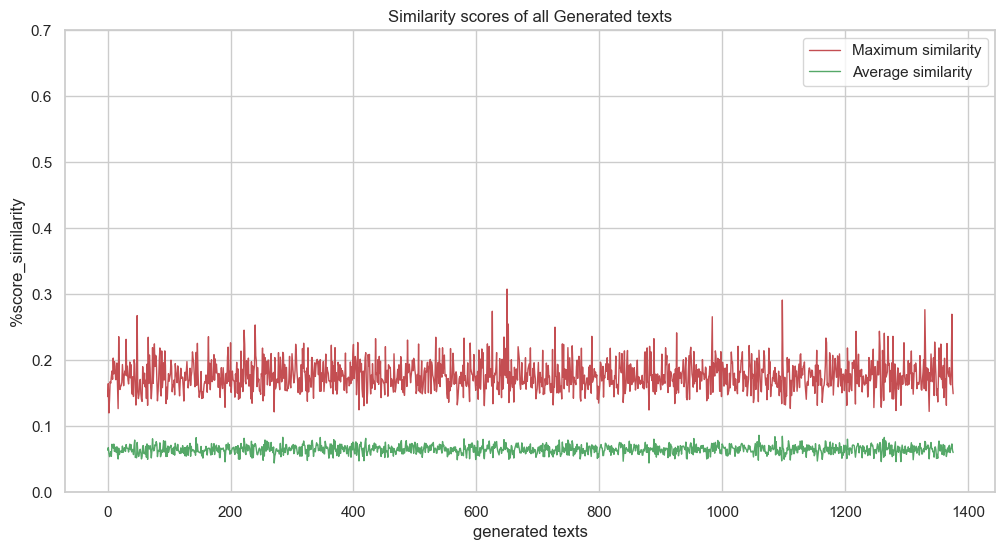

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(max_similarity, color='r', label='Maximum similarity', linewidth=1.0)
plt.plot(avg_similarity, color='g', label='Average similarity', linewidth=1.0)
plt.ylim(0.0,0.7)
plt.xlabel('generated texts')
plt.ylabel('%score_similarity')
plt.title('Similarity scores of all Generated texts')
plt.legend()
plt.show()

###  Correlation between the similarity scores and the prediction probability

So in each iteration we leave a generated text outside the training procedure and then we test it in order to check its probability to be generated.
We downgrade a little bit the number of estimators in order to continue the process and check the results. However, with  n_estimator = 100, the accuracy in the competition was very similar (71.4%).

In [145]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm


def train_model(id, essays, labels):
    """
    Train a Random Forest model with the custom training dataset
    and predict the probability for a new unknown value to be generated
    by an LLM
    :param id: int
    :param essays: series of strings
    :param labels: series of int (0,1)
    :return: float (probability)
    """
    X_test = essays[id]
    X_train = essays.copy(deep=True)
    y_train = labels.copy(deep=True)
    X_train.pop(id)
    y_train.pop(id)

    # Feature extraction
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    X_train = vectorizer.fit_transform(X_train)
    y_train = np.array(y_train)
    X_test = vectorizer.transform([X_test])

    # Model selection
    rf_classifier = RandomForestClassifier(n_estimators=50, random_state=43)

    # Train the RF model
    rf_classifier.fit(X_train, y_train)
    # Predictions
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probability of the positive class
    prob = y_prob[0]

    return prob


In [81]:
# Read the train essays .csv
essays_df = pd.read_csv('data/all_train_essays.csv')
essays_cols = essays_df.columns.tolist()

# Separate the essays and the labels
essays = essays_df[essays_cols[2]]
labels = essays_df[essays_cols[3]]

LLM_index = [i for i, essay in enumerate(essays_df[essays_cols[2]])
                if essays_df.loc[i, essays_cols[3]] == 1]

LLM_proba = []
with tqdm(total=len(LLM_index)) as pbar:
    try:
        for id in LLM_index:
            prob = train_model(id, essays, labels)
            LLM_proba.append(prob)
            pbar.update(1)  # Update the progress bar
    except Exception as e:
        LLM_proba.append(0.5)
        pbar.update(1)  # Update the progress bar


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1377/1377 [2:39:46<00:00,  6.96s/it]


### Plot the probability with similarity scores

We are going to plot our final results with the similarity scores in order to check any correlation between these metrics. 
Moreover, we are going to if any generated essay has low probability in order to remove it. 
We will update the .csv file with the scores and add the probabilities.

In [82]:
scores_df['probability'] = LLM_proba
print(scores_df)
scores_df.to_csv('data/similarity_scores.csv')

          max_similarity  avg_similarity  probability
id                                                   
82131f68        0.144828        0.063668         0.06
86fe4f18        0.164474        0.067493         0.12
eafb8a56        0.120000        0.059768         0.06
a511f0bc        0.140385        0.053855         1.00
0a033739        0.167382        0.056457         0.98
...                  ...             ...          ...
d064edec        0.162698        0.064581         0.94
132f51fa        0.186120        0.067506         1.00
9c68a172        0.269608        0.073106         0.98
43e88f59        0.161880        0.063216         1.00
daa0735a        0.149194        0.060088         0.98

[1377 rows x 3 columns]


### Plot similarity scores and probabilities


In [3]:
import pandas as pd

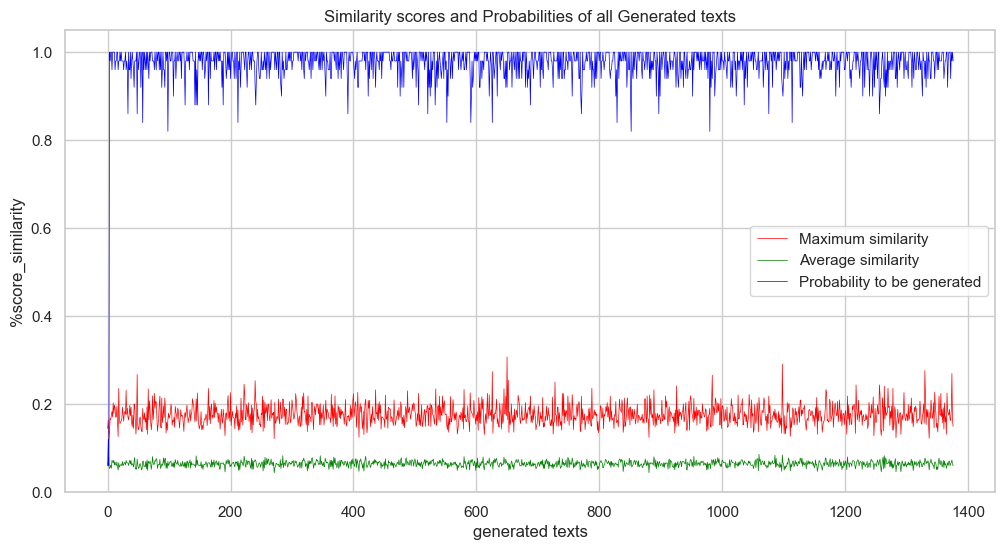

In [146]:
import matplotlib.pyplot as plt


scores_df = pd.read_csv('data/similarity_scores.csv')
cols = scores_df.columns.tolist()
max_similarity = scores_df[cols[1]].tolist()
avg_similarity = scores_df[cols[2]].tolist()
probabilities = scores_df[cols[3]].tolist()

plt.figure(figsize=(12,6))
plt.plot(max_similarity, color='red', label='Maximum similarity', linewidth=0.5)
plt.plot(avg_similarity, color='green', label='Average similarity', linewidth=0.5)
plt.plot(probabilities, color='blue', label='Probability to be generated', linewidth=0.5)
plt.ylim(0.0,1.05)
plt.xlabel('generated texts')
plt.ylabel('%score_similarity')
plt.title('Similarity scores and Probabilities of all Generated texts')
plt.legend()
plt.show()

<Figure size 5000x600 with 0 Axes>

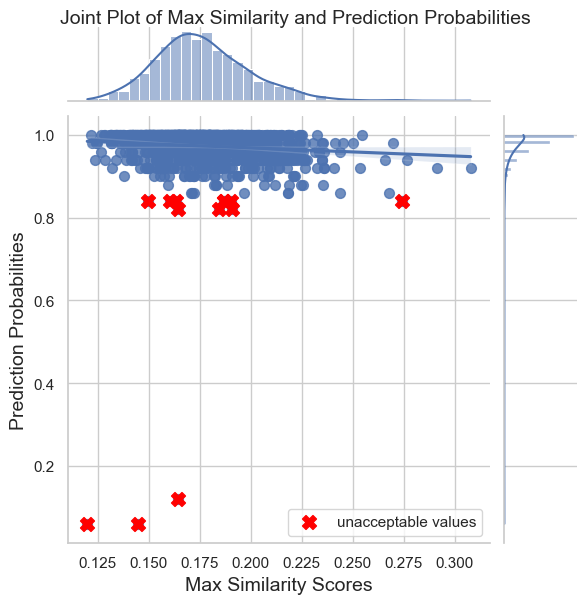

In [147]:
import seaborn as sns

# Creation of a more understandable plot
my_df = pd.DataFrame({'Max Similarity': max_similarity, 'Probabilities': probabilities})

plt.figure(figsize=(50,6))
sns.set(style="whitegrid")
joint_plot = sns.jointplot(x='Max Similarity', y='Probabilities', data=my_df, kind='reg', height=6, scatter_kws={'s': 50})

# Set axis labels
joint_plot.set_axis_labels('Max Similarity Scores', 'Prediction Probabilities', fontsize=14)

joint_plot.fig.suptitle('Joint Plot of Max Similarity and Prediction Probabilities', y=1, fontsize=14)

highlight_condition = (my_df['Probabilities'] <= 0.85)
joint_plot.ax_joint.scatter(data.loc[highlight_condition, 'Max Similarity'],
                            data.loc[highlight_condition, 'Probabilities'],
                            color='red', marker='X', s=100, label='unacceptable values')

joint_plot.ax_joint.legend()

# Show the plot
plt.show()

## Comments on the results


As we can see from the results and plots, the first generated essays has very low probability that they need to be removed in order to improve our classifier. We can observe low similarity scores for almost all the generated essays. However, if we check closer we can observe probabilities that are close to 0.8. In comparison to the similarity scores we can spot a small correlation between them for the reason that the probabilities of generated essays that are close to 0.8 have similarity scores 0.14 - 0.18.

In conclusion, by combining our metrics and the above results we can mention that we cannot trust entirely our classification report for the reason that it gives us perfect metrics, however if you test each generated essay some might misclassify. 

In order to remove efficiently the generated essays that might be misclassified and train incorrectly our classifier, we are going to add a **threshold**. So, we are going to remove from our training dataset the generated essays that have a probability of classified correctly lower that 85% (prob<0.85). 

For that purpose we are going to use our .csv file that we had already stored all the scores and probabilities with the id's with the .csv file that contains all the trained essays. We are going to store the remaining trained essays in a new .csv file named 'best_trained_essays' 

In [148]:
scores_df = scores_df.set_index('id')
all_train_essays_df = pd.read_csv('data/all_train_essays.csv', index_col=0)

for row, values in scores_df.iterrows():
    if values.iloc[2] < 0.85:
        all_train_essays_df = all_train_essays_df.drop(row)

print(all_train_essays_df)
all_train_essays_df.to_csv('data/best_train_essays.csv')

          prompt_id                                               text  \
id                                                                       
0059830c          0  Cars. Cars have been around since they became ...   
005db917          0  Transportation is a large necessity in most co...   
008f63e3          0  "America's love affair with it's vehicles seem...   
00940276          0  How often do you ride in a car? Do you drive a...   
00c39458          0  Cars are a wonderful thing. They are perhaps o...   
...             ...                                                ...   
d064edec          1  Dear ,\n\nAs a concerned student in , I am wri...   
132f51fa          0  Reducing car usage can offer numerous advantag...   
9c68a172          1  Dear Senator,\n\nI am writing to advocate for ...   
43e88f59          0  In recent years, initiatives to limit car usag...   
daa0735a          1  Dear Senator ,\n\nI am writing to express my v...   

          generated  
id             

### Train our model again


In [136]:
train_essays_df = pd.read_csv('data/best_train_essays.csv')
rf_classifier, accuracy_scores2, vectorizer = train_rf_model(rf_classifier, train_essays_df)

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       136

    accuracy                           1.00       273
   macro avg       1.00      1.00      1.00       273
weighted avg       1.00      1.00      1.00       273



### Save our model again 

In [129]:
import joblib

# Save the retrained model to a file 
model_filename = 'random_forest_model.joblib'
joblib.dump(rf_classifier, model_filename)

['random_forest_model.joblib']

## Better results compared to the previous...(slightly but better)

Plot in order to check the different accuracies between the Random Forest with all_trained_essays and best_trained_essays.
As we can see from the following results in the initial training set some test sets do not achieve the optimum, thus we claim that in these test sets are the inefficient essays which were disregarded.

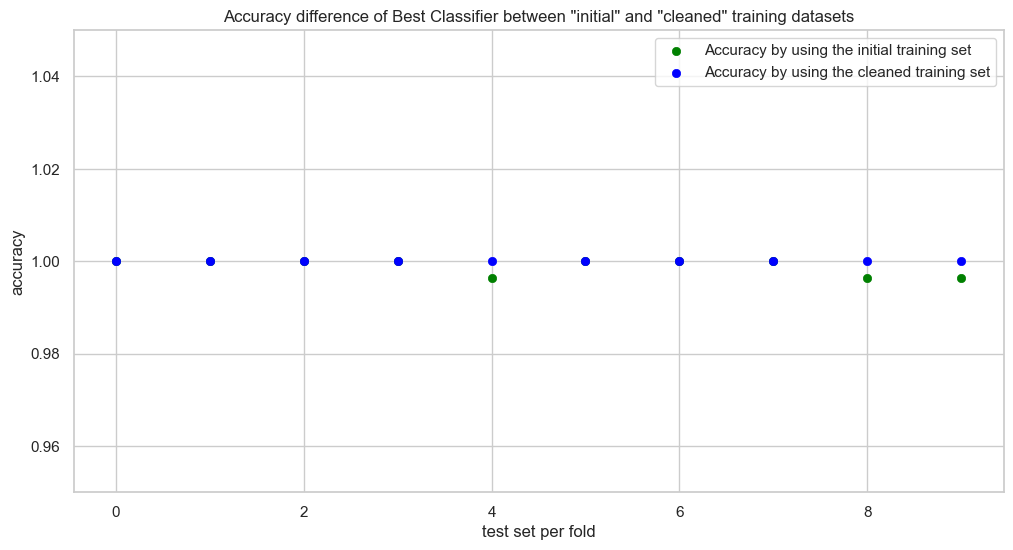

In [186]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(accuracy_scores1)), accuracy_scores1, color='green', label='Accuracy by using the initial training set', linewidth=0.5)
plt.scatter(range(len(accuracy_scores2)), accuracy_scores2, color='blue', label='Accuracy by using the cleaned training set', linewidth=0.5)
plt.ylim(0.95,1.05)
plt.xlabel('test set per fold')
plt.ylabel('accuracy')
plt.title('Accuracy difference of Best Classifier between "initial" and "cleaned" training datasets')
plt.legend()
plt.show()

## Learning curves

We are going to hide a test set in order to evaluate our classifier based on the portions of datasets that we will train it. 
For each portion (10%, 20%,....100%) we are going to use two metrics: accuracy and F1-score. Moreover, for each portion we will evaluate our classifier based on the hidden test and the training set.
We will plot the accuracies and F1-scores in order to spot any malfucntion of our dataset(underfitting, overfitting etc).

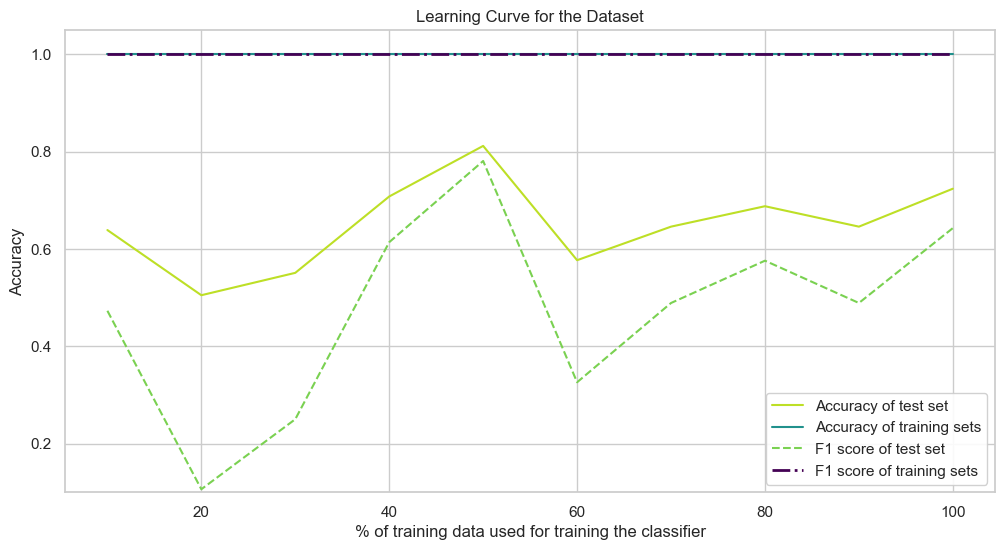

In [152]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import seaborn as sns


def train_rf_model(X_train, y_train, X_test, y_test):
    """
    Train a Random Forest model with portion of training
    dataset. Test it with the hidden test set and/or the same
    portion of training set and calculate accuracy and F1 score
    :param X_train: array of strings (essays)
    :param y_train: array of ints (labels 0,1)
    :param X_test: array of strings (essays)
    :param y_test: array of ints (labels 0,1)
    :return: floats (accuracy and F1 score)
    """
    # Feature extraction
    vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=6000)
    Xtrain = vectorizer.fit_transform(X_train)
    ytrain = np.array(y_train)
    Xtest = vectorizer.fit_transform(X_test)
    ytest = np.array(y_test)

    # Model selection
    rf_classifier = RandomForestClassifier(n_estimators=200, random_state=43)

    # Train the SVM model
    rf_classifier.fit(Xtrain, ytrain)

    # Predictions
    y_pred = rf_classifier.predict(Xtest)

    # Evaluate the model
    accuracy = accuracy_score(ytest, y_pred)
    # report = classification_report(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    accuracy_rounded = round(accuracy, 3)
    f1_rounded = round(f1, 3)
    return accuracy_rounded, f1_rounded


def plotting_curves(test_accuracies, train_accuracies, F1_test, F1_trains, labeltitle):
    """
    Plotting curves for the accuracies and F1 scores which originated by 
    the above function. 
    :param test_accuracies: array of floats (accuracies from test set)
    :param train_accuracies: array of floats (accuracies from train set)
    :param F1_test: array of floats (F1 scores from test set)
    :param F1_trains: array of floats (F1 scores from train set)
    :return: None. Just shows the plot
    """
    percentages = [i * 10 for i in range(1, 11)]
    sns.set(style="whitegrid")
    viridis = plt.get_cmap('viridis')

    plt.figure(figsize=(12, 6))
    plt.plot(percentages, test_accuracies, color=viridis(0.9), label='Accuracy of test set', linewidth=1.5)
    plt.plot(percentages, train_accuracies, color=viridis(0.5), label='Accuracy of training sets', linewidth=1.5)
    plt.plot(percentages, F1_test, color=viridis(0.8), linestyle='--', label='F1 score of test set', linewidth=1.5)
    plt.plot(percentages, F1_trains, color=viridis(0.0),linestyle='-.', label=labeltitle, linewidth=2)
    plt.ylim(0.1, 1.05)
    plt.xlabel('% of training data used for training the classifier')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve for the Dataset')
    plt.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9)
    plt.show()


# Read the train essays .csv from the cleaned essays
train_essays_df = pd.read_csv('data/best_train_essays.csv')
essays_cols = train_essays_df.columns.tolist()
# Separate the essays and the labels
essays = train_essays_df[essays_cols[2]]
labels = train_essays_df[essays_cols[3]]

X_train, X_test, y_train, y_test = train_test_split(essays, labels, test_size=0.2,
                                                    random_state=43, shuffle=True)

n_split = len(X_train)
accuracies_test = []
f1_test = []
accuracies_train = []
f1_train = []

for i in range(1, 11):
    Xtrain = X_train[:int(i*0.1 * n_split)]
    ytrain = y_train[:int(i*0.1 * n_split)]

    acc_portion_test, f1_portion_test = train_rf_model(Xtrain, ytrain, X_test, y_test)
    accuracies_test.append(acc_portion_test)
    f1_test.append(f1_portion_test)
    acc_portion_train, f1_portion_train = train_rf_model(Xtrain, ytrain, Xtrain, ytrain)
    accuracies_train.append(acc_portion_train)
    f1_train.append(f1_portion_train)
label_title = 'F1 score of training sets'
plotting_curves(accuracies_test, accuracies_train, f1_test, f1_train, label_title)

### Results

As we can see from the above plot we can claim that the 10-fold cross validation does not work efficiently for our dataset, for the reason that we are overfitting the problem. We can spot that with portions our classifier cannot predict efficient the unknown essays. 
In the first portions (10%, 20%) the prediction are very unsatisfying. Moreover, we can spot that as the portion increases the estimations are better. However, for some portions(10-20% & 50-60%) our metrics decrease very much, so we can spot there that the dataset we inserted is insufficient and abnormal.
On the other hand when we make predictions for the training dataset we can spot that the accuracy and F1 score has the best results. So, with these conclusions we can spot an overfitting in our data, thus we must increase our dataset in order to balance the problem.  

In [156]:
y = np.array(accuracies_test + f1_test)
y.reshape(1, -1)
X = np.array([i * 10 for i in range(1, 11)] + [i * 10 for i in range(1, 11)])

def calc_theta(X, Y):
    """
    Calculate the theta of datapoints accuracies & f1_scores using
    linear regression (Least Squares method)
    :param X: np.array of floats (dataset X),
    :param Y: np.array of ints (dataset y),
    :return: np.array of floats (theta)
    """
    aces = [1 for i in range(len(X))]
    X = np.column_stack((aces, X))
    XtX = np.dot(np.transpose(X), X)
    XtX_inverse = np.linalg.inv(XtX)
    XtY = np.dot(np.transpose(X), Y)
    my_theta = np.dot(XtX_inverse, XtY)
    return my_theta


def calc_x(a, b, y):
    """
    Estimate the percentage of required dataset in order the
    accuracy-f1_score to become 100%
    :param a: float (θ0)
    :param b: float (θ1)
    :param y: int (1)
    :return: float (percentage of required dataset)
    """
    p = (y-a)/(b*100)
    print(f'The required percentage of essays in order the accuracy and/or f1 score to become 1.00 is: {p*100:.1f}%')
    p_rounded = round(p, 4)
    return p_rounded

theta = calc_theta(X, y)
print(f'theta parameters are: θ0: {theta[0]}, θ1:{theta[1]}')
y_essays = calc_x(theta[0], theta[1], 1)
y_essays
required_essays = y_essays*len(train_essays_df)
print(f'The required essays are: {int(required_essays)}')

theta parameters are: θ0: 0.44503333333333267, θ1:0.0021293939393939388
The required percentage of essays in order the accuracy and/or f1 score to become 1.00 is: 260.6%
The required essays are: 7138


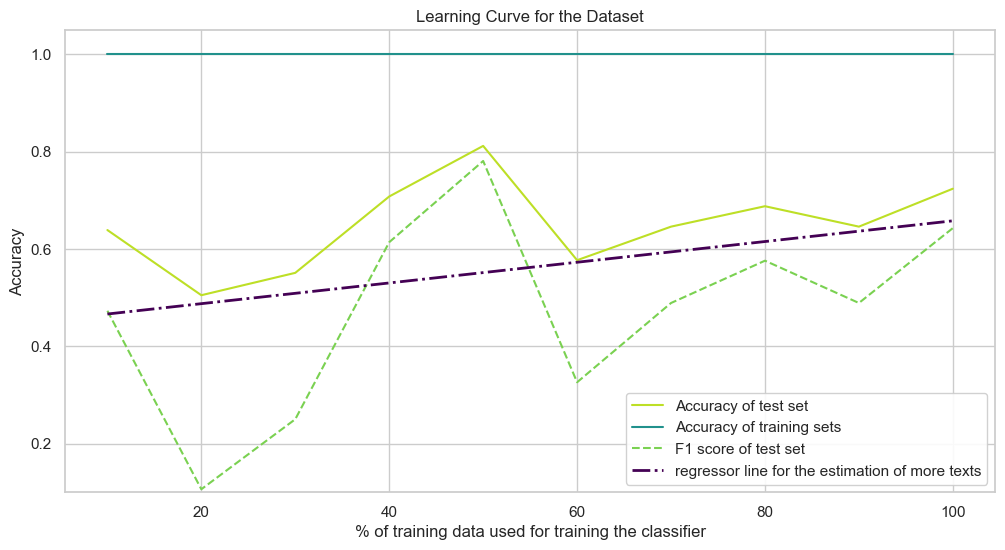

In [157]:
def calc_f(a, b, x):
    """
    Estimate yi's based on calculated thetas
    :param a: float (θ0)
    :param b: float (θ1)
    :param y: int (percentage)
    :return: float (y)
    """
    y = a + b*x
    return y 
    
y_line = [calc_f(theta[0], theta[1], x) for x in range(10, 110, 10)]
label_title = 'regressor line for the estimation of more texts'
plotting_curves(accuracies_test, accuracies_train, f1_test, y_line, label_title)

# Clustering-based augmentation

We are going to use k-means algorithm in order to make clusters for both student and LLM essays. So, we will create two clustering in which the first will try to create clusters for the LLM essays and the other will try to create clusters for student essays.

We must find the optimum number of clusters for each clustering, thus we will use the elbow method in order to find the optimum k. 
With this method we will plot an elbow and we have to select the value of k at the “elbow” at the point after which the distortion/inertia starts decreasing in a linear way

### We will start with the student essays

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


# Read the train essays .csv
essays_df = pd.read_csv('data/best_train_essays.csv')
essays_cols = essays_df.columns.tolist()
# Separate the essays and the labels
essays = essays_df[essays_cols[2]]

### Find the optimum k for LLM essays

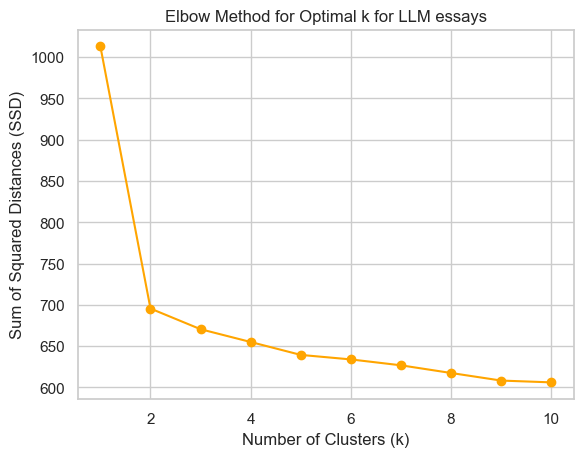

In [4]:
import seaborn as sns



# Extract the LLM essays for the dataframe
LLM_essays = [essay for i, essay in enumerate(essays_df[essays_cols[2]])
                if essays_df.loc[i, essays_cols[3]] == 1]

vectorizer = TfidfVectorizer(stop_words='english')
X_LLM = vectorizer.fit_transform(LLM_essays)

k_values = range(1, 11)
# Compute the Sum of Squared Distances (SSD)
ssd_LLM = []
for k in k_values: # Compute until 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_LLM)
    ssd_LLM.append(kmeans.inertia_)

# Plot the Elbow Curve
sns.set(style="whitegrid")
plt.plot(k_values, ssd_LLM, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal k for LLM essays')
plt.show()

### Find the optimum k for student essays

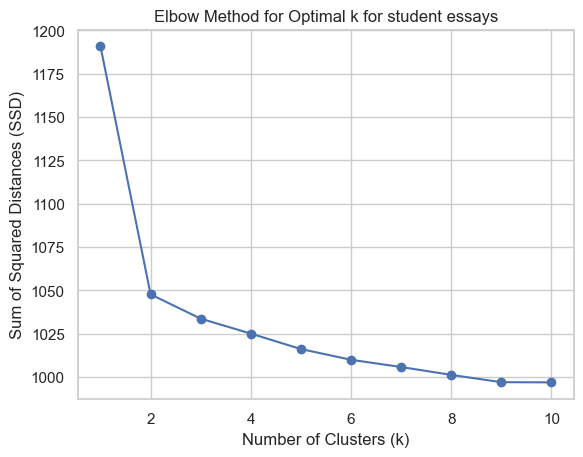

In [165]:
# Extract the LLM essays for the dataframe
student_essays = [essay for i, essay in enumerate(essays_df[essays_cols[2]])
                if essays_df.loc[i, essays_cols[3]] == 0]

vectorizer = TfidfVectorizer(stop_words='english')
X_student = vectorizer.fit_transform(student_essays)

# Compute the Sum of Squared Distances (SSD)
ssd_student = []
for k in k_values: # Compute until 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_student)
    ssd_student.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_values, ssd_student, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal k for student essays')
plt.show()

### Comment on the results

As we can see from the above plots the optimum k is k=2 or k=3 for both student/LLM essays. So we are going to implement another technique in order to estimate the optimum k between 2 and 3. The technique we are going to implement is the silhouette method and this method calculates a score between the different clusters. The best score shows the optimum k for the clustering. 

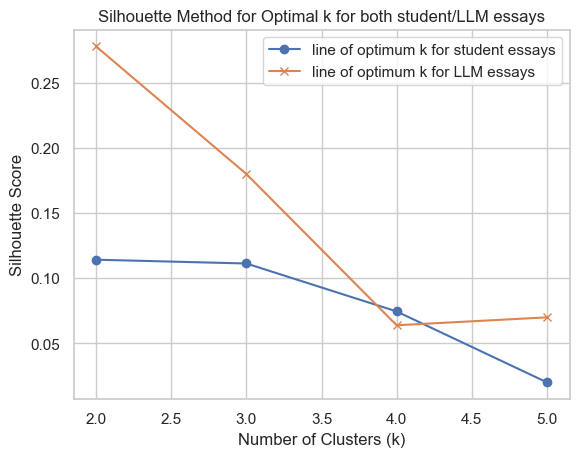

In [166]:
from sklearn.metrics import silhouette_score

silhouette_scores_students = []
silhouette_scores_LLM = []
k_values = range(2, 6)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42,  n_init=10)
    cluster_labels_st = kmeans.fit_predict(X_students)
    silhouette_avg_st = silhouette_score(X_students, cluster_labels_st)
    silhouette_scores_students.append(silhouette_avg_st)
    cluster_labels_LLM = kmeans.fit_predict(X_LLM)
    silhouette_avg_LLM = silhouette_score(X_LLM, cluster_labels_LLM)
    silhouette_scores_LLM.append(silhouette_avg_LLM)
    
# Plot the Silhouette Scores for students
plt.plot(k_values, silhouette_scores_students, marker='o', label='line of optimum k for student essays')
plt.plot(k_values, silhouette_scores_LLM, marker='x', label='line of optimum k for LLM essays')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k for both student/LLM essays')
plt.legend()
plt.show()


### Optimum k for clustering

So, totally the best/optimum k for clustering is k=2 for both student/LLM essays. We can spot that for LLM essays the difference between k=2 and k=3 is very big. On the other hand for student essays the difference between k=2 and k=3 is very small, however we will pick the more efficient based on the silhoutte scores. 

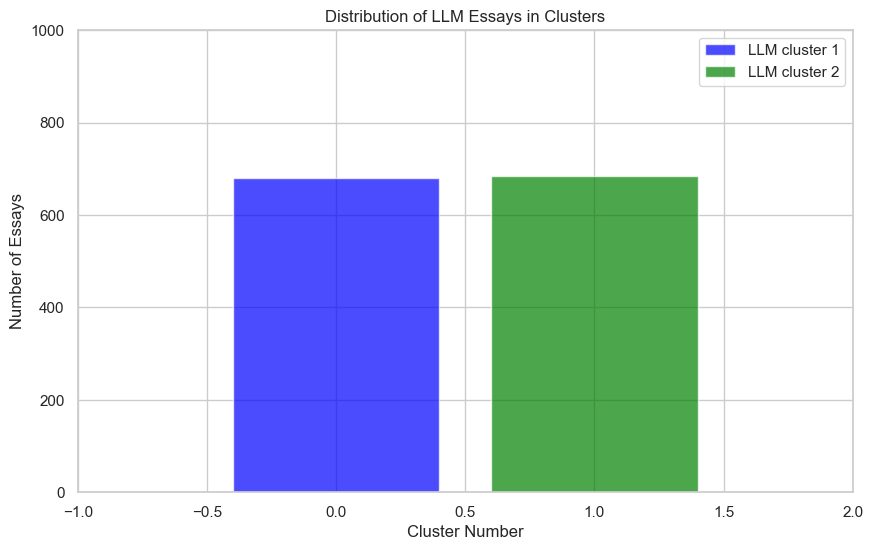

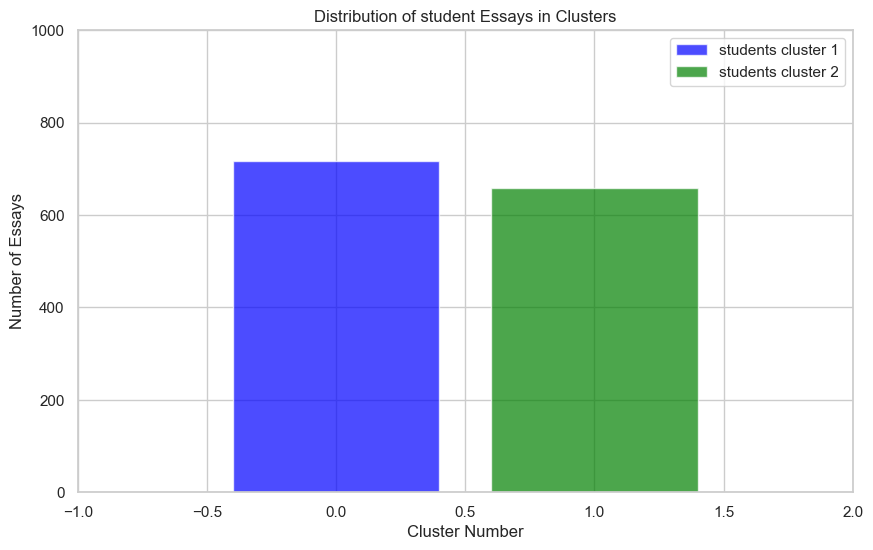

In [169]:
import pandas as pd
import numpy as np


def clustering_essays(dataset, optimal_k=2):
    """
    Make a clustering of k clusters for a dataset
    that contains essays.
    :param dataset: list of essays
    :param optimal_k: int
    :return: array of ints (the labels)
    :return: two arrays (1st array contains the labels and the 2nd the number of
    essays on each cluster)
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans.fit(dataset)
    cluster_labels = kmeans.labels_
    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)

    return cluster_labels, unique_clusters, cluster_counts


def bar_plot(essay_name, cluster_labels, cluster_counts, labels):
    """
    Plot via bars the clusters of each group essay in order to 
    compare the number of each cluster (check the balance)
    :param essay_name: str (name of essay group)
    :param cluster_labels: array of ints (the labels of each cluster)
    :param cluster_counts: array of ints (the number of essays for each cluster)
    :param labels: arrays of strings (labels in order to present better the bars)
    :return: None (show of bar plot)
    """
    colors = ['blue', 'green']
    plt.figure(figsize=(10,6))
    plt.bar(cluster_labels, cluster_counts, align='center', label=labels, alpha=0.7, color = colors)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Essays')
    plt.xlim(-1,2)
    plt.ylim(0, 1000)
    plt.title(f'Distribution of {essay_name} in Clusters')
    plt.legend()
    plt.show()


# Apply K-Means for LLM essays
cluster_labels_LLM, clusters_LLM, cluster_count_LLM  = clustering_essays(X_LLM)
labels = ['LLM cluster 1', 'LLM cluster 2']
essay_name_LLM = 'LLM Essays'
bar_plot(essay_name_LLM, clusters_LLM, cluster_count_LLM, labels)

# Apply K-Means for student essays
cluster_labels_students, clusters_students, cluster_count_students = clustering_essays(X_students)
labels = ['students cluster 1', 'students cluster 2']
essay_name_st = 'student Essays'
bar_plot(essay_name_st, clusters_students, cluster_count_students, labels)

### Balance on data

From the above plots we observe that the clusters of LLM generated essays are well balanced, thus we do not need to create more essays in order to balance the dataset. On the other hand, the clusters of student essays are not perfectly balanced, thus we might need to generate more essays for cluster No2. 

In [170]:
# Create the clusters of the two clusterings for both LLM and students
cluster1_LLM = [essay for i, essay in enumerate(LLM_essays)
                  if cluster_labels_LLM[i] == 0]

cluster2_LLM = [essay for i, essay in enumerate(LLM_essays)
                  if cluster_labels_LLM[i] == 1]

cluster1_students = [essay for i, essay in enumerate(student_essays)
                  if cluster_labels_students[i] == 0]

cluster2_students = [essay for i, essay in enumerate(student_essays)
                  if cluster_labels_students[i] == 1]

print(f'For the essays that are generated by an LLM')
print(f'The number of essays in cluster No1 is: {len(cluster1_LLM)}')
print(f'The number of essays in cluster No1 is: {len(cluster2_LLM)}')
print('--------------------------------------------------------')
print(f'For the essays that are written by students')
print(f'The number of essays in cluster No1 is: {len(cluster1_students)}')
print(f'The number of essays in cluster No1 is: {len(cluster2_students)}')

For the essays that are generated by an LLM
The number of essays in cluster No1 is: 680
The number of essays in cluster No1 is: 684
--------------------------------------------------------
For the essays that are written by students
The number of essays in cluster No1 is: 717
The number of essays in cluster No1 is: 658


## Creation of augmentation.csv file

In the following code we will add the clusters for each text, so with this meta-information we are going to save it in a csv file ('augmentation.csv'), with all the generated essays that we created via GPT API. 

In [185]:
# Add the clusters into the dataframe
step_st=0
step_LLM=0
for i in range(len(essays_df)):
    if essays_df.loc[i, essays_cols[3]] == 0:
        essays_df.loc[i, 'cluster'] = 'student_C' +str(cluster_labels_students[step_st]+1)
        step_st+=1
    else:
        essays_df.loc[i, 'cluster'] = 'LLM_C' +str(cluster_labels_students[step_LLM]+1)
        step_LLM+=1

essays_df = essays_df.set_index(essays_cols[0])
essays_df.to_csv('data/augmentation.csv')

### Find the most common words in order to create a title for each cluster

In [172]:
from sklearn.decomposition import NMF

# Combine essays within each cluster into a single document for topic analysis
cluster1_LLM_text = ' '.join(cluster1_LLM)
cluster2_LLM_text = ' '.join(cluster2_LLM)
cluster1_students_text = ' '.join(cluster1_students)
cluster2_students_text = ' '.join(cluster2_students)


def most_common_words(cluster1, cluster2, n_topic=2, n=-7):
    """
    Caclulation of the most common words for each cluster. 
    By changing the parameter 'n' we can adjust the returned 
    number of most common words
    :param cluster1: list of texts (strings),
    :param cluster2: list of texts (strings),
    :param n_topic: int (topics of clusters)
    :param n: int (influence the number of most common words that will be outputed)
    :return: list of strings (most common words)
    """    
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform([cluster1, cluster2])

    # Fit an NMF model
    num_topics = n_topic
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(X)

    # Get the top words for each topic
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_words = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:n:-1]])

    return top_words


### Print a title based on the most common words

In [173]:
# Assign titles based on the top words in each cluster
LLM_top_words = most_common_words(cluster1_LLM_text, cluster2_LLM_text)
title_cluster1_LLM = f"Cluster 1 (LLM): {' the '.join(LLM_top_words[0])}"
title_cluster2_LLM = f"Cluster 2 (LLM): {' the '.join(LLM_top_words[1])}"
print(title_cluster1_LLM)
print(title_cluster2_LLM)


students_top_words = most_common_words(cluster1_students_text, cluster2_students_text)
title_cluster1_students = f"Cluster 1 (students): {' the '.join(students_top_words[0])}"
title_cluster2_students = f"Cluster 2 (students): {' the '.join(students_top_words[1])}"
print(title_cluster1_students)
print(title_cluster2_students)

Cluster 1 (LLM): electoral the college the vote the states the election the popular
Cluster 2 (LLM): car the usage the transportation the cars the reducing the free
Cluster 1 (students): car the cars the people the pollution the driving the usage
Cluster 2 (students): electoral the college the vote the president the votes the electors


### Fix the titles based on the most common words.

Use of GPT API for this purpose. (use an instance of class PromptingGPT in order to create a prompt and ask GPT)

We will ask for formal titles by combining the most common words. ors

In [174]:
from GPT_Prompting import PromptingGPT

GPT_api = PromptingGPT()

x1 = ','.join(LLM_top_words[0])
x2 = ','.join(LLM_top_words[1])
x3 = ','.join(students_top_words[0])
x4 = ','.join(students_top_words[1])

# Our generalized prompt for all the titles
prompt = "I would like you to create a formal title by given you the following words. Please write only the title: "

# Title for LLM cluster 1
prompt_LLM_cluster_1 = prompt + x1
reply_LLM_cluster_1 = GPT_api.make_prompts_turbo(prompt_LLM_cluster_1)
print(f"Cluster 1 (LLM): {reply_LLM_cluster_1}")

# Title for LLM cluster 2
prompt_LLM_cluster_2 = prompt + x2
reply_LLM_cluster_2 = GPT_api.make_prompts_turbo(prompt_LLM_cluster_2)
print(f"Cluster 2 (LLM): {reply_LLM_cluster_2}")


# Title for students cluster 1
prompt_student_cluster_1 = prompt + x3
reply_student_cluster_1 = GPT_api.make_prompts_turbo(prompt_student_cluster_1)
print(f"Cluster 1 (students): {reply_student_cluster_1}")

# Title for students cluster 2
prompt_student_cluster_2 = prompt + x4
reply_student_cluster_2 = GPT_api.make_prompts_turbo(prompt_student_cluster_2)
print(f"Cluster 2 (students): {reply_student_cluster_2}")

Cluster 1 (LLM): "The Role of the Electoral College in Presidential Elections: Balancing State Votes and the Popular Vote"
Cluster 2 (LLM): "Reducing Car Usage Through Free Transportation"
Cluster 1 (students): "Reducing Pollution from Car Usage: A Study of People's Driving Habits"
Cluster 2 (students): "The Electoral College: A Critical Analysis of Votes, President Selection, and Electors"


### Study the similarities between the two clusterings, by finding clusters comprising similar texts


So we are going to find 300 most common words for each cluster and compare each other in order to find similarities.
From the title we expect that cluster 1 of LLM we be very similar to cluster 2 of students and also the cluster 2 of LLM we be very similar to cluster 1 of students

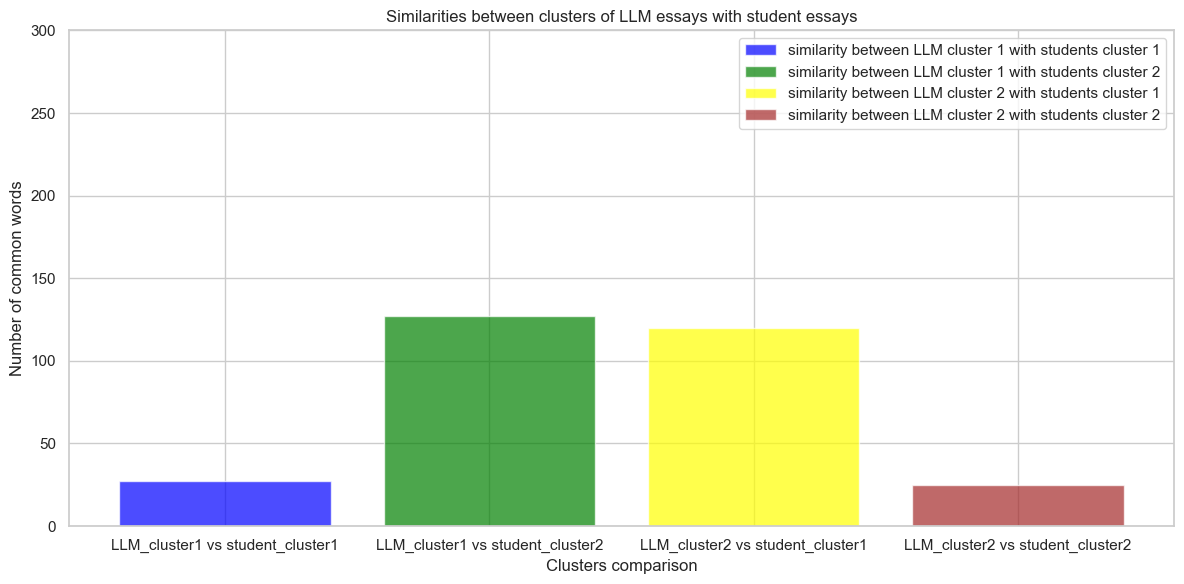

In [175]:
LLM_most_common_words = most_common_words(cluster1_LLM_text, cluster2_LLM_text, n=-300)
students_most_common_words = most_common_words(cluster1_students_text, cluster2_students_text, n=-300)

LLM_most_common_words1 = set(LLM_most_common_words[0])
LLM_most_common_words2 = set(LLM_most_common_words[1])

students_most_common_words1 = set(students_most_common_words[0])
students_most_common_words2 = set(students_most_common_words[1])

count_words_cluster11_LLM = len(LLM_most_common_words1.intersection(students_most_common_words1))
count_words_cluster12_LLM = len(LLM_most_common_words1.intersection(students_most_common_words2))

count_words_cluster21_LLM = len(LLM_most_common_words2.intersection(students_most_common_words1))
count_words_cluster22_LLM = len(LLM_most_common_words2.intersection(students_most_common_words2))

cluster_counts = [count_words_cluster11_LLM, count_words_cluster12_LLM,
                  count_words_cluster21_LLM, count_words_cluster22_LLM]
labels = ['similarity between LLM cluster 1 with students cluster 1',
          'similarity between LLM cluster 1 with students cluster 2', 
           'similarity between LLM cluster 2 with students cluster 1',
          'similarity between LLM cluster 2 with students cluster 2']

cluster_values = ['LLM_cluster1 vs student_cluster1', 'LLM_cluster1 vs student_cluster2',
                 'LLM_cluster2 vs student_cluster1', 'LLM_cluster2 vs student_cluster2']

colors = ['blue', 'green', 'yellow', 'brown']
plt.figure(figsize=(12,6))
plt.bar(cluster_values, cluster_counts, align='center', label=labels, alpha=0.7, color = colors)
plt.xlabel('Clusters comparison')
plt.ylabel('Number of common words')
plt.ylim(0, 300)
plt.title('Similarities between clusters of LLM essays with student essays')
plt.legend()
plt.tight_layout()
plt.show()

### Plot the percentage of similarities between the clusters


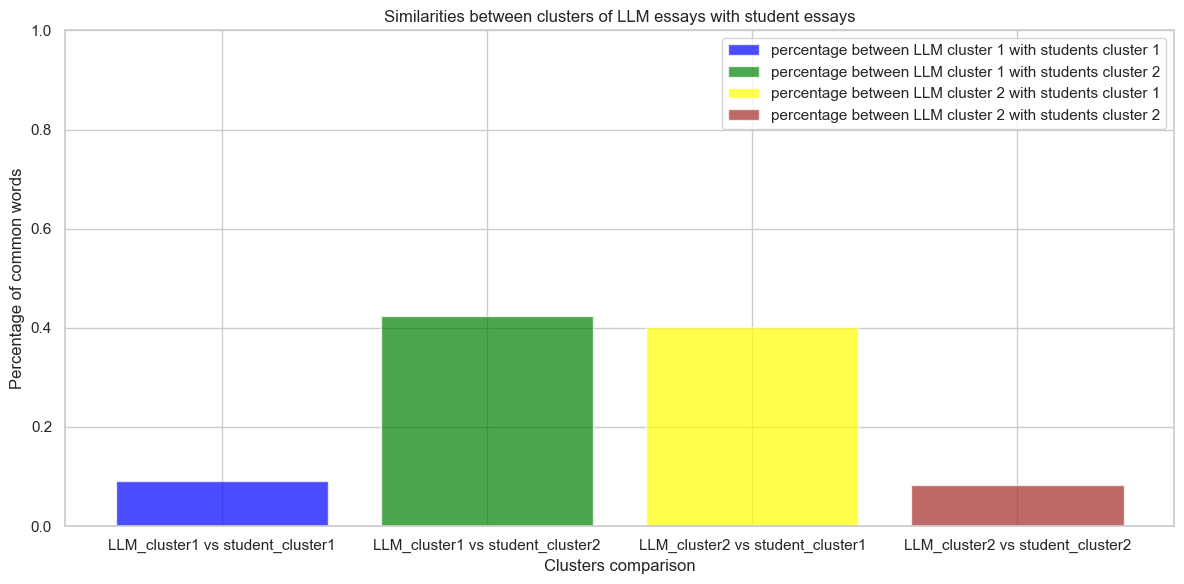

In [176]:
# Similarity Percentage of LLM cluster 1 with cluster of students
percentage_cluster11_LLM = count_words_cluster11_LLM / len(LLM_most_common_words1)
percentage_cluster12_LLM = count_words_cluster12_LLM / len(LLM_most_common_words2)

# Similarity Percentage of LLM cluster 2 with cluster of students
percentage_cluster21_LLM = count_words_cluster21_LLM / len(LLM_most_common_words1)
percentage_cluster22_LLM = count_words_cluster22_LLM / len(LLM_most_common_words2)

cluster_counts = [percentage_cluster11_LLM, percentage_cluster12_LLM,
                 percentage_cluster21_LLM, percentage_cluster22_LLM]
labels = ['percentage between LLM cluster 1 with students cluster 1',
          'percentage between LLM cluster 1 with students cluster 2', 
           'percentage between LLM cluster 2 with students cluster 1',
          'percentage between LLM cluster 2 with students cluster 2']

cluster_values = ['LLM_cluster1 vs student_cluster1', 'LLM_cluster1 vs student_cluster2',
                 'LLM_cluster2 vs student_cluster1', 'LLM_cluster2 vs student_cluster2']

colors = ['blue', 'green', 'yellow', 'brown']
plt.figure(figsize=(12,6))
plt.bar(cluster_values, cluster_counts, align='center', label=labels, alpha=0.7, color = colors)
plt.xlabel('Clusters comparison')
plt.ylabel('Percentage of common words')
plt.ylim(0, 1)
plt.title('Similarities between clusters of LLM essays with student essays')
plt.legend()
plt.tight_layout()
plt.show()


### Comments on the results

As we can see from the above plots LLM_cluster 1 vs student_cluster 2 and LLM_cluster2 vs student_cluster1 has a large percentage of similar words (>40%), so we can spot a common topic between these two pair of clusters.

# Generation of more texts

As we observed by the previous queries the student clustering which contains two (2) clusters is not perfectly balanced. More specifically, cluster No1 has 60 more essays than cluster No2, thus we can produce more essays for cluster No2 in order to have a perfectly balanced dataset. 

Moreover, via the regressor plot we estimated that the required essays are 7138. So, we will add (from external datasets) 4500 more essays in order to reach the required number of essays and re-train our best classifier to see the improve or downgrade. The number of essays that will be imported in our dataset will be balanced (50% LLM - 50% students) for the reason that we want to keep our balance.  

In [177]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


# Add more essays for training based on regressor plot
add_essays_df = pd.read_csv('data/train_drcat_01.csv')
add_essays_cols = add_essays_df.columns.tolist()

# Separate the essays and the labels
add_essays_students = [essay for i, essay in enumerate(add_essays_df[add_essays_cols[0]])
                       if add_essays_df.loc[i, add_essays_cols[1]] == 0]
add_essays_LLM = [essay for i, essay in enumerate(add_essays_df[add_essays_cols[0]])
                       if add_essays_df.loc[i, add_essays_cols[1]] == 1]

add_essays = add_essays_students[:2250] + add_essays_LLM[:2250]
add_labels = [0 for _ in range(2250)] + [1 for _ in range(2250)]

# Vectorize our additional dataset via previous vectorizer
X_additional = vectorizer.fit_transform(add_essays)
y_additional = np.array(add_labels)

### RE-TRAIN OUR BEST CLASSIFIER

In [178]:
from joblib import load

# Load our pretained classifier
rf_classifier = load('random_forest_model.joblib')
# Train on new additional Data
rf_classifier.fit(X_additional, y_additional)

RandomForestClassifier(n_estimators=200, random_state=43)

In [139]:
# Test essays from the given test set
test_essays_df = pd.read_csv('data/test_essays.csv')
test_essays = test_essays_df['text']
test_essays_X = vectorizer.transform(test_essays)
predicted_test_set = rf_classifier.predict_proba(test_essays_X)
results_df = pd.DataFrame({'id':test_essays_df['id'], 'generated': predicted_test_set[:, 1]})
results_df = results_df.set_index('id')
print(results_df)

# Save the results to a CSV file
results_df.to_csv('data/submission_final.csv')

          generated
id                 
0000aaaa       0.82
1111bbbb       0.82
2222cccc       0.82


The final score in the competition with the additional dataset was 73.5% (best score so far).

## Comments on clustering and generation of more essays

During the process of clustering we observed the following:

- If we use k-means we always need to find the optimum k via efficient methods (elbow, silhouette etc).
- Clustering can give us a very good 'taste' of our dataset. We can observe inbalanced data and the number of different topics (clusters). In          clustering we can evaluate our dataset and generate (or remove) data in order to better train the classifier. In our specific task it is vital to    own a balanced dataset and also it is very important to know the different topics of our dataset in order to check if we must generate new data      per topic.
- Finally, via clustering we can identify patterns and group similar instances, and based on that we can generate or remove essays and train our classifier more efficiently. 